# Min distance objective

Optimal


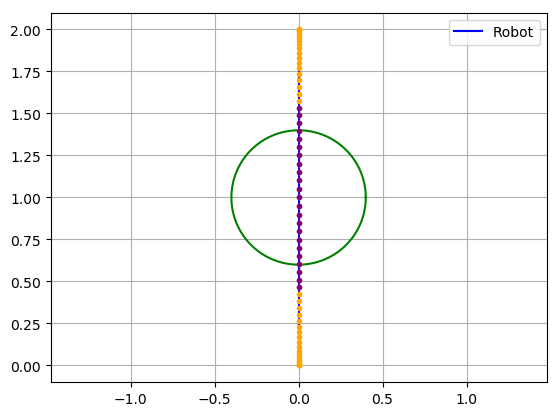

Total Distance: 2.0
Total Acceleration: 36.61016949152543
Start: (0, 0)
Finish: (0, 2)


In [58]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 60           # simulation time
start = [0, 0]      # starting location
finish = [0, 2]     # ending location

sand = [0 1]        # Center of circle representing sand
r_sand = 0.4        # Radius of circle representing sand

num_sand, dim = size(sand)


# Variables
@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time]) 
#@variable(m, z[1:time], Bin) # create binary variable for z[t]=1 when path through sand, z[t]=zero otherwise

@constraint(m, x_A[:, 1] .== start) # Robot initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot initial velocity 

# Conditional constraint for z=1 when going through sand, need different solver (or algorithm for NLopt solver)
# m_lower = r_sand^2
# epsilon = 0.001
# for t in 1:time
#     for c in 1:num_sand
#     @NLconstraint(m, r_sand^2 - ((x_A[1,t]-sand[c,1])^2 + (x_A[2,t]-sand[c,2])^2 )  >= m_lower*z[t] + epsilon*(1-z[t])) 
#     end
# end

# Set parameters for conditional constraint applying external force on motion
F_drag = 20
mass = 10
m_sand = -10000000
z = zeros(time)
start_sand = 20
end_sand = 42

# Set z[i]=1 for specified time steps
for i in start_sand:end_sand
    z[i] = 1
end


#############################################################
# Comment/uncomment the below out to turn off/on the sand pit

# for t in 1:time-1
#     # if z[t] = 1, then apply external force to increase amount of acceleration needed
#     @constraint(m, u_A[:,t+1] - ((u_A[:,t] + F_drag/mass)) .>= m_sand*(1-z[t+1]) )
# end
#############################################################

# Dynamic equations
factor = 1/3600
for t in 1:time-1    
     @constraint(m, x_A[:, t+1] .== x_A[:, t] + factor*v_A[:, t]) # Robot position    
     @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# True total distance traveled
d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

# True total acceleration
u_tot_actual = 0
for t in 1:time-1
   u_tot_actual += sqrt( (getvalue(u_A[1,t+1])-getvalue(u_A[1,t]))^2 + (getvalue(u_A[2,t+1])-getvalue(u_A[2,t]))^2) 
end

# Output
x_A = getvalue(x_A)
println("Total Distance: ", d_tot_actual)
println("Total Acceleration: ", u_tot_actual)
println("Start: (", start[1],", ", start[2],")")
println("Finish: (", finish[1],", ", finish[2],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")

# Plot sand
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_sand
    plot( sand[c,1] .+ r_sand*cos.(t), sand[c,2] .+ r_sand*sin.(t), color="green")  # plot circle radius r with center (x1, x2)
end

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Plot points with applied force
for t in start_sand:end_sand
    plot(x_A[1, t], x_A[2, t], ".", color="purple")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

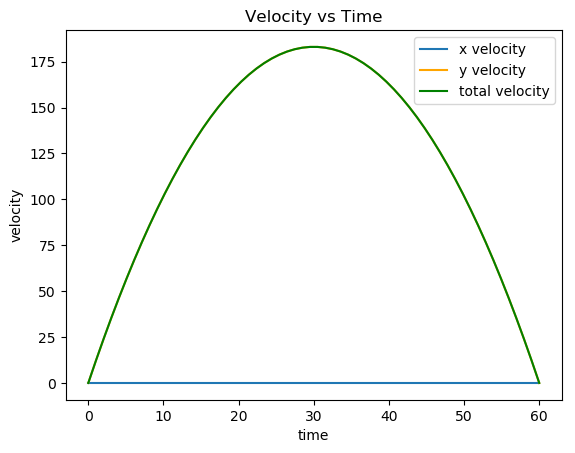

In [59]:
# Velocity plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x velocity")
plot(x[:], getvalue(v_A)[2,:], label="y velocity", color = "orange")
total_v = (getvalue(v_A[1,:]).^2 + getvalue(v_A[2,:]).^2).^0.5
plot(x, total_v, label="total velocity", color="green")
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

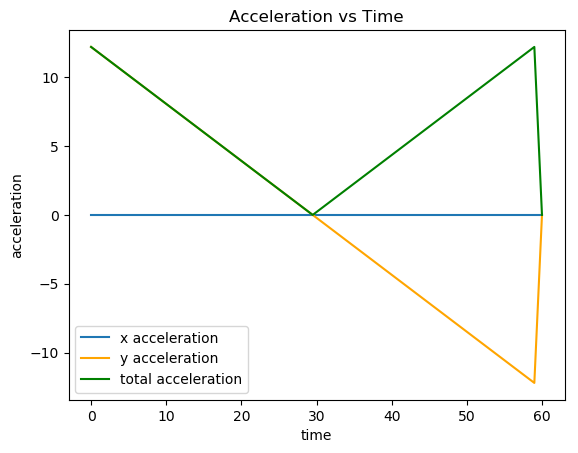

In [60]:
# Acceleration plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x acceleration")
plot(x[:], getvalue(u_A)[2,:], label="y acceleration", color = "orange" )
total_u = (getvalue(u_A[1,:]).^2 + getvalue(u_A[2,:]).^2).^0.5
plot(x, total_u, label="total acceleration", color="green")
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

In [242]:
using JuMP
using NLopt

m = Model(solver=NLoptSolver(algorithm=:LD_MMA))

a1 = 2
b1 = 0
a2 = -1
b2 = 1

@variable(m, x1)
@variable(m, x2 >= 0)

@NLobjective(m, Min, sqrt(x2))
@NLconstraint(m, x2 >= (a1*x1+b1)^3)
@NLconstraint(m, x2 >= (a2*x1+b2)^3)

setvalue(x1, 1.234)
setvalue(x2, 5.678)

status = solve(m)

println("got ", getobjectivevalue(m), " at ", [getvalue(x1),getvalue(x2)])

got 0.5443310477213124 at [0.333333, 0.296296]


In [277]:
A = [0 0 0;
     0 1 0;
     0 0 0]

x = [1 1 1;
     1 0 0;
     1 0 0]

b = A*x
println(A.*x)

[0 0 0; 0 0 0; 0 0 0]
